In [1]:
import os, time, copy
from collections import OrderedDict
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as vmodels
import torchvision.datasets as vdatasets

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.patches as patches
import matplotlib.font_manager as fm
path = '/Library/Fonts/NanumBarunGothicBold.ttf'
fontprop = fm.FontProperties(fname=path, size=18)

from PIL import Image as pil_image

import numpy as np
from skimage.transform import resize
from skimage.measure import label, regionprops

torch.manual_seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
BATCH_SIZE = 4

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(197),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize((197, 197)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [4]:
data_dir = "../datasets/presidential_candidates_2017/"
image_datasets = {x: vdatasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'validation']}

dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=BATCH_SIZE, shuffle=True),
               'validation': torch.utils.data.DataLoader(image_datasets['validation'], BATCH_SIZE, shuffle=False)}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
nb_classes = len(image_datasets['train'].classes)

In [5]:
class Resnet_fc(nn.Module):
    def __init__(self, base_model, nb_classes):
        super(Resnet_fc, self).__init__()

        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-2])

        tmp = OrderedDict()
        tmp['last_conv'] = nn.Conv2d(2048, nb_classes, 1, 1)
        tmp['gap'] = nn.AvgPool2d(kernel_size=7, stride=1, padding=0)

        self.classifier_layer = nn.Sequential(tmp)

    def forward(self, inputs):
        features = self.feature_extractor(inputs)
        x = self.classifier_layer(features)
        return x, features

In [21]:
base_model = vmodels.resnet50(pretrained=False)
net = Resnet_fc(base_model, 5)
net.load_state_dict(torch.load("../weights/pred_fullyconv/acolbase_e13.pth.tar", map_location='cpu'))
# net.load_state_dict(torch.load("../weights/pred_fullyconv/best_model_e16_val_acc0.95.pth.tar", map_location='cpu'))
net.eval()
net.to(device)


Resnet_fc(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64

In [22]:
image_datasets['train'].class_to_idx

{'ahn': 0, 'hong': 1, 'moon': 2, 'sim': 3, 'you': 4}

In [23]:
img_path = "samples/moon3.JPG"
cls = 2


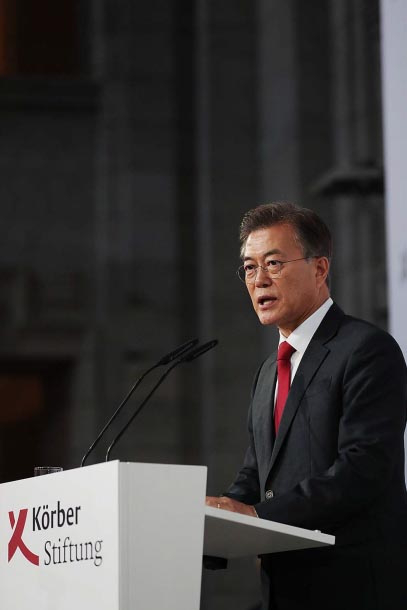

In [24]:
pil_image.open(img_path)

In [25]:
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

def run_cam(img_path, cls, factor):

    img = pil_image.open(img_path)
    img_array = (np.asarray(img)[:, :, :3] / 255.).astype(float)
    n_H, n_W, n_C = img_array.shape
    
    img_array = resize(img_array, (int(n_H * factor), int(n_W * factor)))
    n_H, n_W, n_C = img_array.shape
    to_feed = copy.deepcopy(img_array)

    inp_tensor = normalize(torch.from_numpy(to_feed.transpose(2, 0, 1))).unsqueeze(0).float()
    inp_tensor = inp_tensor.to(device)

    outputs, features = net(inp_tensor)
    cls_output = torch.max(outputs, dim=1)[1][0, :, :]
    print(cls_output)
    print((F.softmax(outputs, dim=1) > 0.9).size())
    return outputs
    s_1, s_2 = features.size()[2:]
    sl_1 = s_1-7+1
    sl_2 = s_2-7+1
    
    W_conv = net.classifier_layer.last_conv.weight.detach()
    W_conv_c = W_conv[cls]
    
    A_conv_c = torch.zeros(1, s_1, s_2)
    for i in range(sl_1):
        for j in range(sl_2):
            a_conv_c = (features[:, :, i:i+7, j:j+7] * W_conv_c).sum(1)
            A_conv_c[:, i:i+7, j:j+7] = torch.max(A_conv_c[:, i:i+7, j:j+7], a_conv_c)
    _min = A_conv_c.min(-1, keepdim=True)[0].min(-2, keepdim=True)[0]
    _max = A_conv_c.max(-1, keepdim=True)[0].max(-2, keepdim=True)[0]
    A_conv_c_normalized = (A_conv_c - _min) / (_max - _min)
    canvas = A_conv_c_normalized[0].detach().numpy()

    plt.imshow(img_array)
    plt.imshow(resize(canvas, (n_H, n_W)), cmap='jet', alpha=0.5)
    plt.axis("off")
    plt.show()

In [26]:
for i in range(5):
    outputs = run_cam("samples/all.jpg", i, 1)
    break

/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


tensor([[ 2,  0,  0,  0,  0,  0,  4,  4,  4,  4,  4,  4],
        [ 2,  0,  0,  0,  0,  0,  4,  4,  4,  4,  4,  4],
        [ 2,  0,  0,  0,  0,  0,  3,  4,  4,  4,  4,  1]])
torch.Size([1, 5, 3, 12])


In [27]:
softmax_outputs = F.softmax(outputs, dim=1)
thres_outputs = softmax_outputs >= 0.4
cls_exists = (thres_outputs.sum(-1).sum(-1) > 0).numpy().tolist()

In [28]:
test_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [29]:
cls2name = {0: '안철수', 1: '홍준표', 2:'문재인', 3:'심상정', 4:'유승민'}
cls2color = {0: 'green', 1: 'red', 2:'blue', 3:'yellow', 4:'teal'}

In [36]:
def run_inference(img_path, is_heatmap, save=False, save_dir=None):
    img = pil_image.open(img_path)
    img_array = np.asarray(img)[:, :, :3]
    n_H, n_W, n_C = img_array.shape
    
    to_feed = copy.deepcopy(img_array)
    inp_tensor = test_transforms(to_feed).unsqueeze(0).float()
    inp_tensor = inp_tensor.to(device)
    
    output, features = net(inp_tensor)
    max_label = torch.max(F.softmax(output[0], dim=0), dim=0)[1].int()
    thres = (torch.max(F.softmax(output[0], dim=0), dim=0)[0] < 0.8)
    extracted_labels = [x for x in np.unique(max_label.masked_fill(thres, -1).view(-1).numpy()).tolist() if x != -1]
    
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.imshow(img_array)
    ax.axis("off")
    
    if len(extracted_labels) > 0:
        
        for cls in extracted_labels:
    
            s_1, s_2 = features.size()[2:]

            sl_1 = s_1-7+1
            sl_2 = s_2-7+1

            W_conv = net.classifier_layer.last_conv.weight.detach()
            W_conv_c = W_conv[cls]
            
            A_conv_c = torch.zeros(1, s_1, s_2)
            for i in range(sl_1):
                for j in range(sl_2):
                    a_conv_c = (features[:, :, i:i+7, j:j+7] * W_conv_c).sum(1)
                    A_conv_c[:, i:i+7, j:j+7] = torch.max(A_conv_c[:, i:i+7, j:j+7], a_conv_c)
            _min = A_conv_c.min(-1, keepdim=True)[0].min(-2, keepdim=True)[0]
            _max = A_conv_c.max(-1, keepdim=True)[0].max(-2, keepdim=True)[0]
            A_conv_c_normalized = (A_conv_c - _min) / (_max - _min)
            canvas = resize(A_conv_c_normalized[0].detach().cpu().numpy(), (n_H, n_W))
            
            if is_heatmap:
                ax.imshow(canvas, cmap='jet', alpha=0.5)
            else:
                labeled = label(canvas > 0.5)
                props = regionprops(labeled)
                
                rects = []
                for p in props:
                    ys, xs, ye, xe = p.bbox
                    w = xe - xs
                    h = ye - ys
                    
                    if w * h > 3000:
                        print(w, h)

                        rect = patches.Rectangle((xs, ys), w, h, linewidth=3, edgecolor=cls2color[cls], facecolor='none', alpha=0.75)
                        rects.append(rect)
                        ax.text(x=xs + 5, y=ys + 23, s=cls2name[cls], fontproperties=fontprop, color=cls2color[cls])

                for r in rects:
                    ax.add_patch(r)
                    
    
    if save:
        fname = os.path.basename(img_path)
        full_path = os.path.join(save_dir, fname)
        fig.savefig(full_path, bbox_inches='tight')
        print("saved - {}".format(full_path))
    else:
        plt.show()

/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


112 113
94 85
175 113
88 87


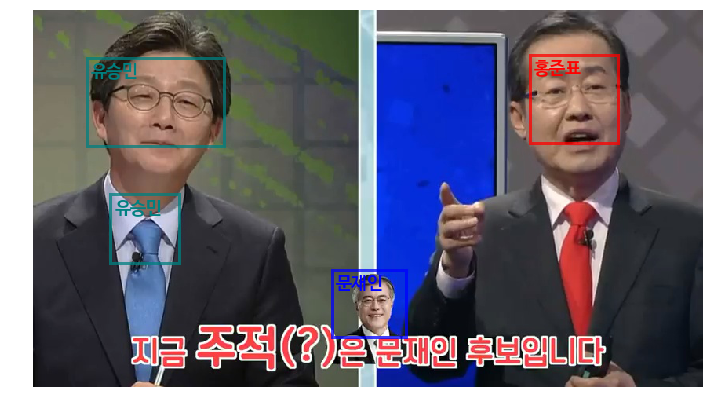

In [37]:
# run_inference("samples/moon3.jpg", is_heatmap=False, save=False, save_dir='video_res')
run_inference("../datasets/presidential_debate_frames_v2/frame040.jpg", is_heatmap=False, save=False, save_dir=None)

In [38]:
paths = glob("samples/*.jpg")

/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


158 128


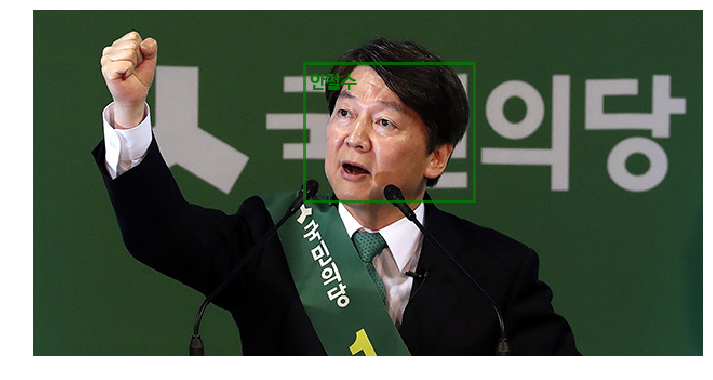

142 144
138 102


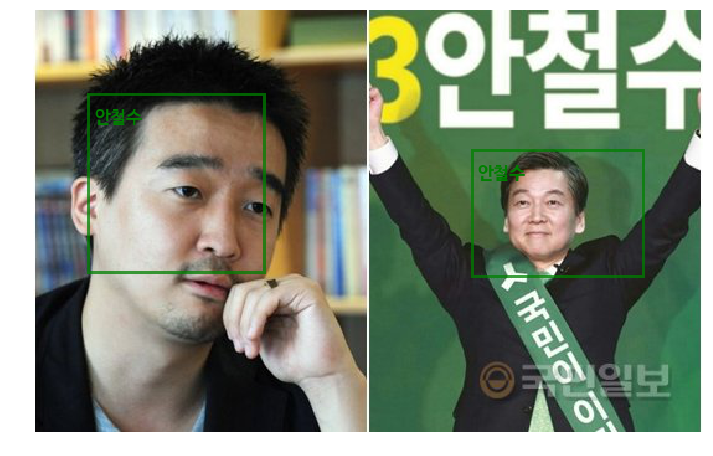

131 128


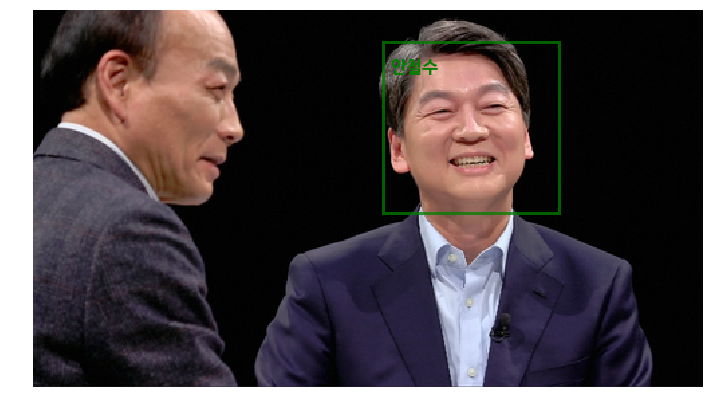

120 106
111 91
106 98


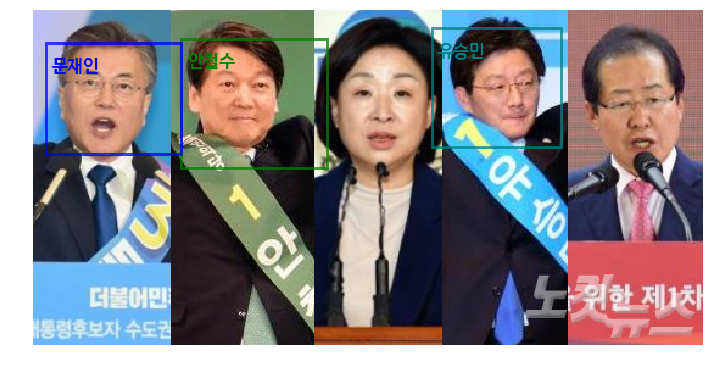

110 98
110 103
103 98


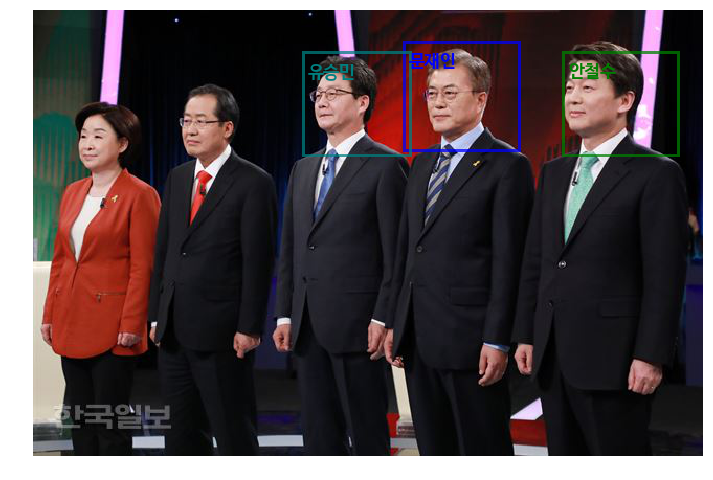

213 99
104 94


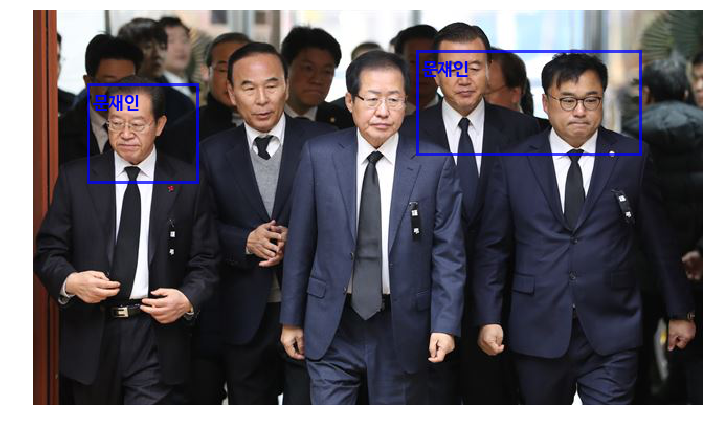

111 208


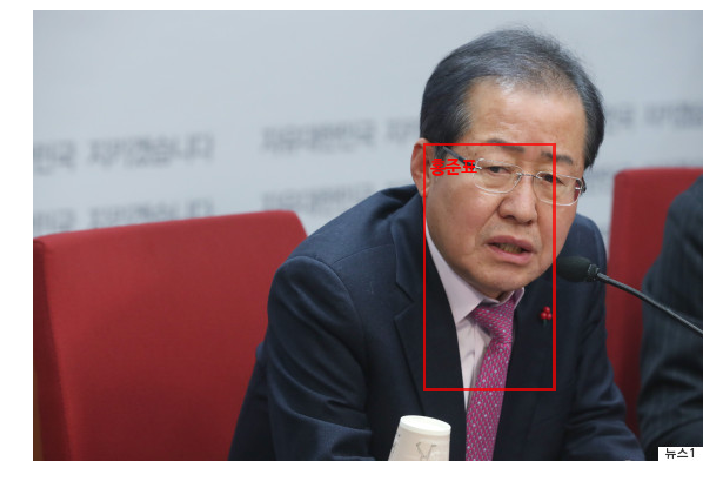

105 165


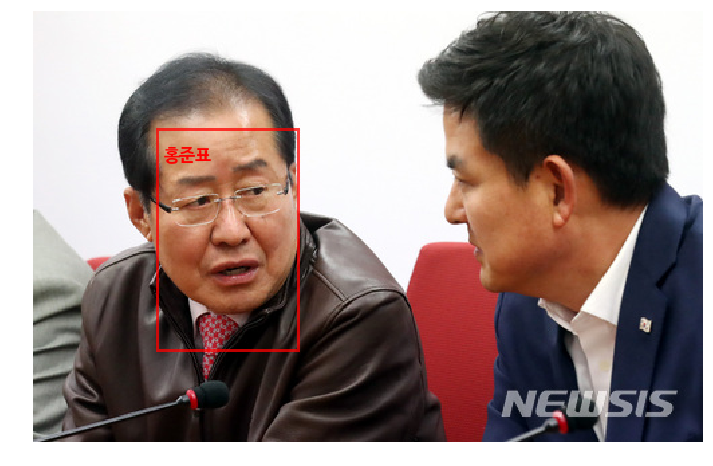

103 90


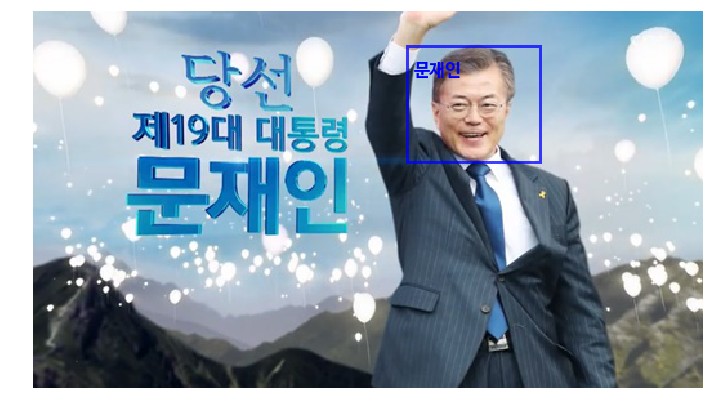

111 96


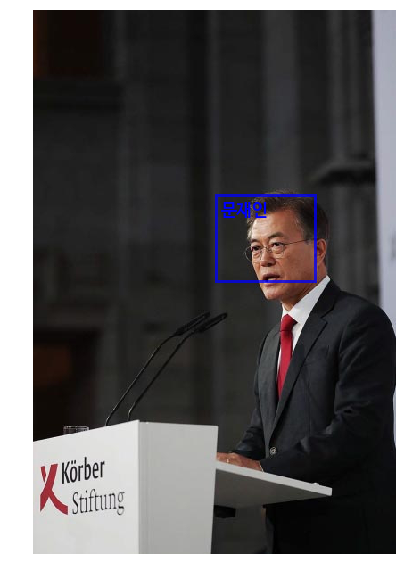

359 173
143 88


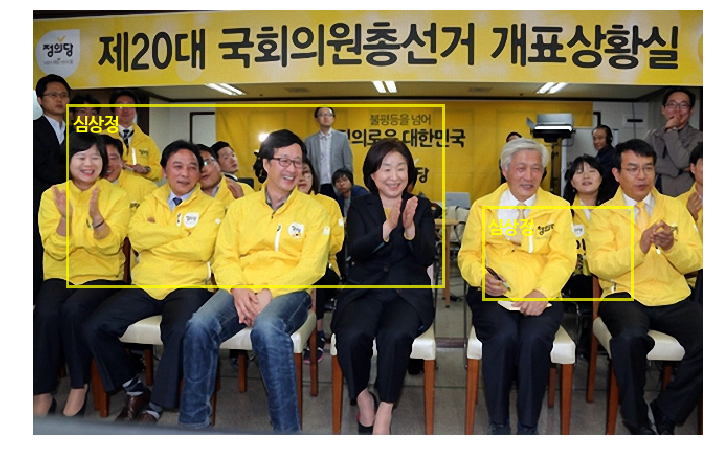

180 148


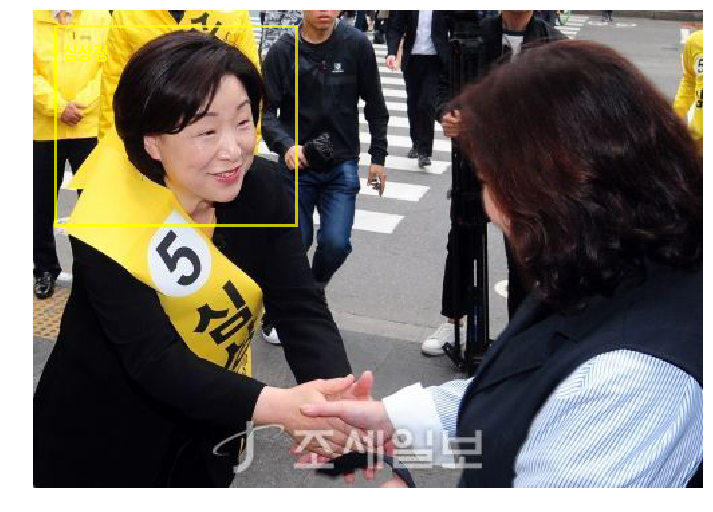

139 108


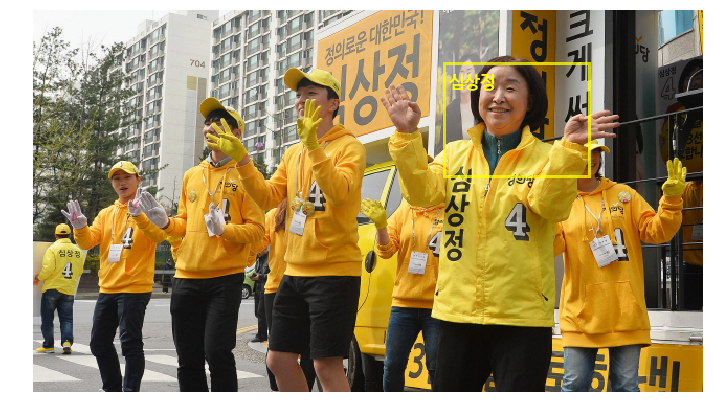

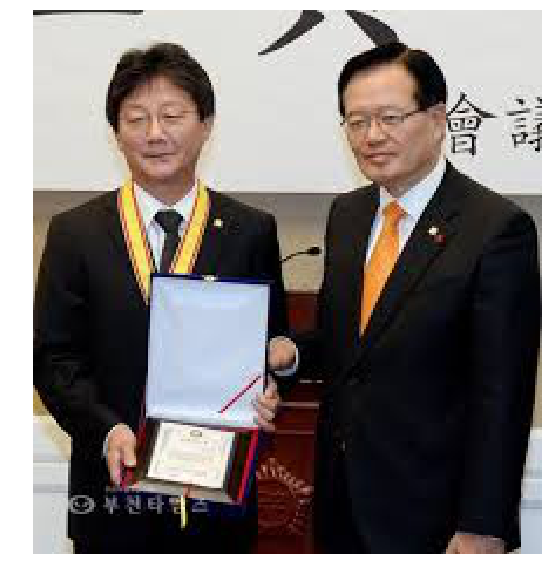

140 197


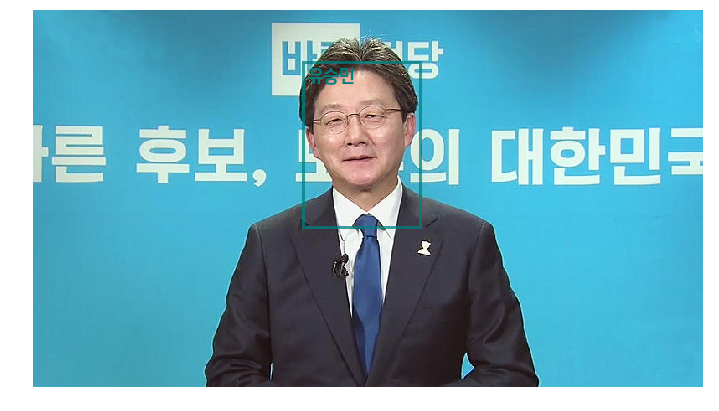

123 130
125 134


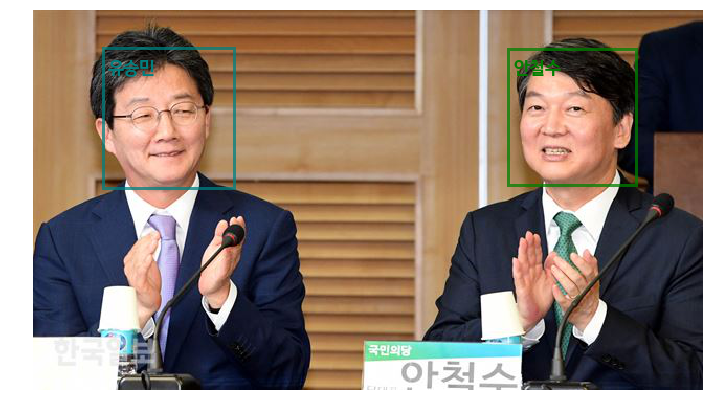

In [41]:
for p in paths:
    run_inference(p, is_heatmap=False, save=False, save_dir=None)